# MLPClassifier para encuesta Reddit Chile

## Conexión a fuente de datos

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

# Selección de variables predictoras y de respuesta.

In [4]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [5]:
# creamos ahora muestras de entrenamiento y prueba seleccionadas aleatoriamente:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [6]:
# datos de entrenamiento antes de balance 
y_train.value_counts()

1    517
0    419
Name: politica_izquierda, dtype: int64

In [7]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [8]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# Cross-Validation y ajuste

In [9]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier

# modelo logístico base
mlp = MLPClassifier(alpha = 0, 
                    hidden_layer_sizes = (100),
                    max_iter = 1000,
                    activation = 'tanh',
                    random_state = 42)

modelo_mlp = mlp.fit(X_train, y_train)

# Validación cruzada
cv = cross_validate(modelo_mlp,
                    X,
                    y,
                    cv = 5,
                    n_jobs = cores,
                    return_train_score = True)
cv

{'fit_time': array([5.45349789, 5.51404858, 5.60910058, 5.4869287 , 5.65232444]),
 'score_time': array([0.00199509, 0.00199461, 0.00199413, 0.00268483, 0.00201559]),
 'test_score': array([0.55982906, 0.58547009, 0.6025641 , 0.56837607, 0.58547009]),
 'train_score': array([0.95405983, 0.94230769, 0.9465812 , 0.94444444, 0.94337607])}

In [11]:
from sklearn.metrics import accuracy_score

print('Accuracy:')
print(accuracy_score(y_test, modelo_mlp.predict(X_test)))

Accuracy:
0.5982905982905983


# Resultados modelo

## Matrices de confusión

In [12]:
y_pred_train = modelo_mlp.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, 
                            columns=["Y_predicha"],index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en Muestra de Entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en Muestra de Entrenamiento:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       517
           1       0.89      0.94      0.91       517

    accuracy                           0.91      1034
   macro avg       0.91      0.91      0.91      1034
weighted avg       0.91      0.91      0.91      1034



In [13]:
y_pred_test = modelo_mlp.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, 
                           columns=["Y_predicha"],index = y_test.index)

print("Resultado en Muestra de Prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en Muestra de Prueba:
              precision    recall  f1-score   support

           0       0.64      0.46      0.53       117
           1       0.58      0.74      0.65       117

    accuracy                           0.60       234
   macro avg       0.61      0.60      0.59       234
weighted avg       0.61      0.60      0.59       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 58% de las veces.  
**Recall**: El modelo es capaz de identificar al 74% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 60% de las veces.

## Curva ROC

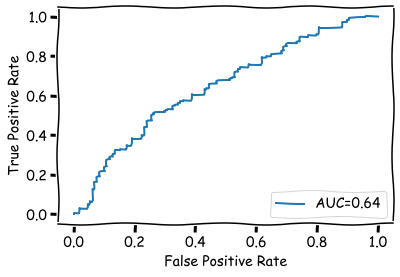

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo_mlp.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Curva PR

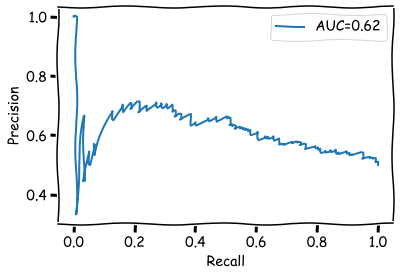

In [15]:
with plt.xkcd():
    pr = metrics.precision_recall_curve(y_test, y_prob_test)
    auc_pr = round(metrics.average_precision_score(y_test, y_prob_test), 2)
    plt.plot(pr[1], pr[0], label="AUC="+str(auc_pr))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc=1)
    plt.show()